## Libraries

In [2]:
import math
import sys
import os
from pathlib import Path
import warnings
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Pre-processing
from sklearn.preprocessing import (MinMaxScaler, StandardScaler, OneHotEncoder,
                                   PolynomialFeatures, OrdinalEncoder)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import (train_test_split, GridSearchCV, 
                                     RandomizedSearchCV, StratifiedKFold,
                                    RepeatedStratifiedKFold)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config

# Model eval                                   
from sklearn.inspection import permutation_importance
from sklearn.metrics import (precision_recall_curve, make_scorer, mutual_info_score, 
                             r2_score, confusion_matrix, classification_report, 
                             RocCurveDisplay, auc, roc_auc_score, fbeta_score)
                                   
# models                                   
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (GradientBoostingClassifier, RandomForestClassifier, 
                              VotingClassifier)
from xgboost import XGBClassifier
                                   
# imbalanced classification
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
                                   
# Handle constant/duplicates and missing features/columns
from feature_engine.selection import (DropFeatures, DropConstantFeatures, 
                                      DropDuplicateFeatures)

# own lib                                   
path = Path(os.path.abspath(''))
util_path = str(path.parent.absolute())

if util_path not in sys.path:
    sys.path.append(util_path)
    
from utils import helpers
                                   
# configs  
set_config(display="diagram")  # make pipeline visible
pd.set_option('display.max_columns',None)
plt.style.use("fivethirtyeight")
np.seterr(divide = 'ignore')
warnings.filterwarnings('ignore')

## Import Data

In [3]:
def get_churn_data():
    data = pd.read_csv("../data/raw/telco-churn-data.csv")
    return data

In [4]:
# change total charges into number, convert churn into 1/0

df = (get_churn_data()
     .assign(Churn = lambda x: np.where(x['Churn']=='Yes', 1, 0),
             TotalCharges= lambda x: pd.to_numeric(x['TotalCharges'], errors='coerce'),
             SeniorCitizen = lambda x: np.where(x['SeniorCitizen']==1, "Yes", "No"),
             NPhoneServices = lambda x: x.PhoneService.map({"No": 0, "Yes": 1}) +
                                        x.MultipleLines.map({"No phone service": 0, "No": 0, "Yes": 1})
            )
      .rename(columns={'tenure': 'Tenure'})
      .dropna(subset=['TotalCharges'])#
      .drop(columns=['customerID'], axis=1)
     )

# make columns which is: 1) number of phone services, 2) number of internet services
internet_add_ons = df.columns[8:14]
df['NInternetServices'] = df[internet_add_ons].apply(lambda x: np.where(x=='Yes', 1, 0)).sum(axis=1) + np.where(df.InternetService=="No", 0, 1)

# change strs to categories
cat_cols = df.select_dtypes('object').columns.tolist() + ['NPhoneServices', 'NInternetServices']
df[cat_cols] = df[cat_cols].astype('category')

In [5]:
X = df.drop('Churn', axis=1)
y = df['Churn']
TARGET_NAME = 'Churn'
classes = ['No Churn', 'Churned']

X[['NInternetServices', 'NPhoneServices']] = X[['NInternetServices', 'NPhoneServices']].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

cat_cols = X.select_dtypes('category').columns
num_cols = X.select_dtypes(np.number).columns

In [6]:
display(df.head(5))
df.info()

,gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,NPhoneServices,NInternetServices
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0,2
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,1,3
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,1,3
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,0,4
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,1,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   gender             7032 non-null   category
 1   SeniorCitizen      7032 non-null   category
 2   Partner            7032 non-null   category
 3   Dependents         7032 non-null   category
 4   Tenure             7032 non-null   int64   
 5   PhoneService       7032 non-null   category
 6   MultipleLines      7032 non-null   category
 7   InternetService    7032 non-null   category
 8   OnlineSecurity     7032 non-null   category
 9   OnlineBackup       7032 non-null   category
 10  DeviceProtection   7032 non-null   category
 11  TechSupport        7032 non-null   category
 12  StreamingTV        7032 non-null   category
 13  StreamingMovies    7032 non-null   category
 14  Contract           7032 non-null   category
 15  PaperlessBilling   7032 non-null   category
 16  Paymen

## EDA

1. Visualize all the cols
2. Check for outliers
3. Random forest feature importance
4. Check target distribution
5. Check for missing values

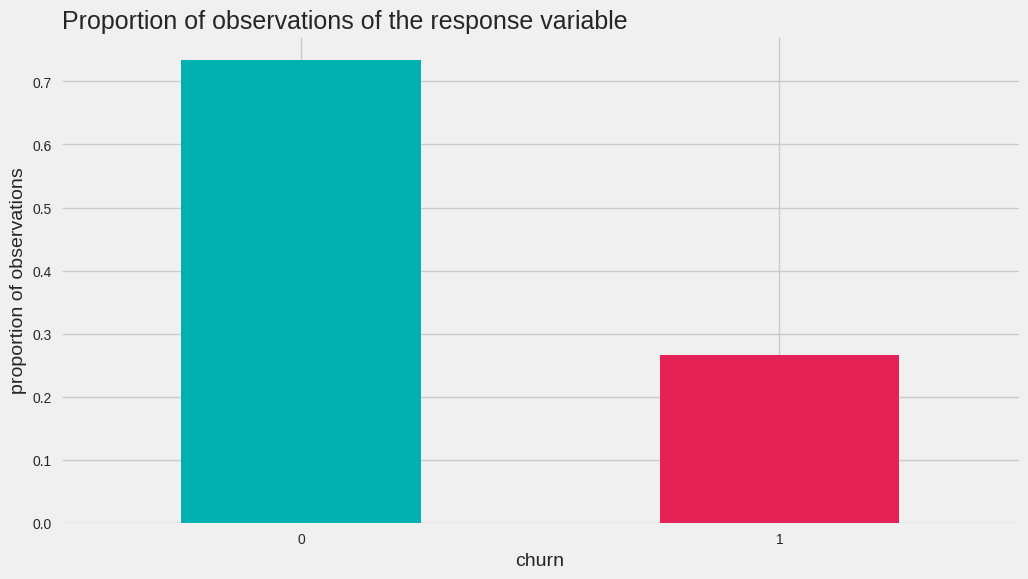

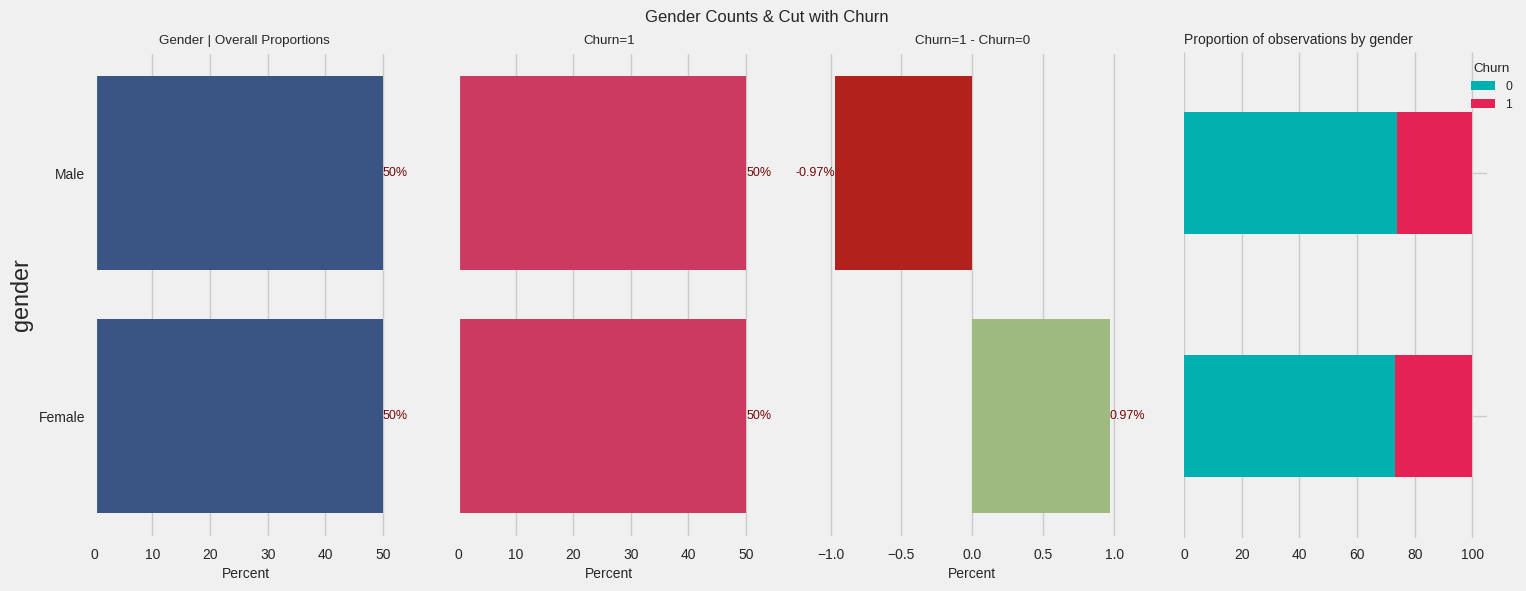

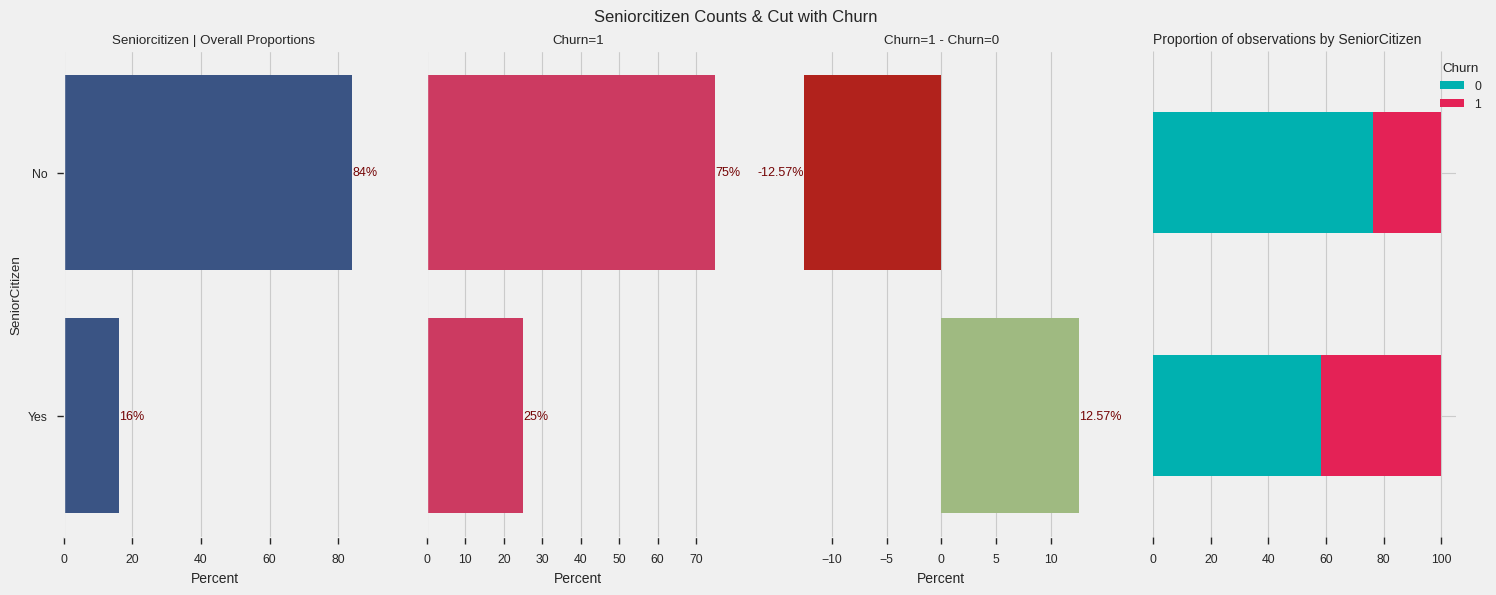

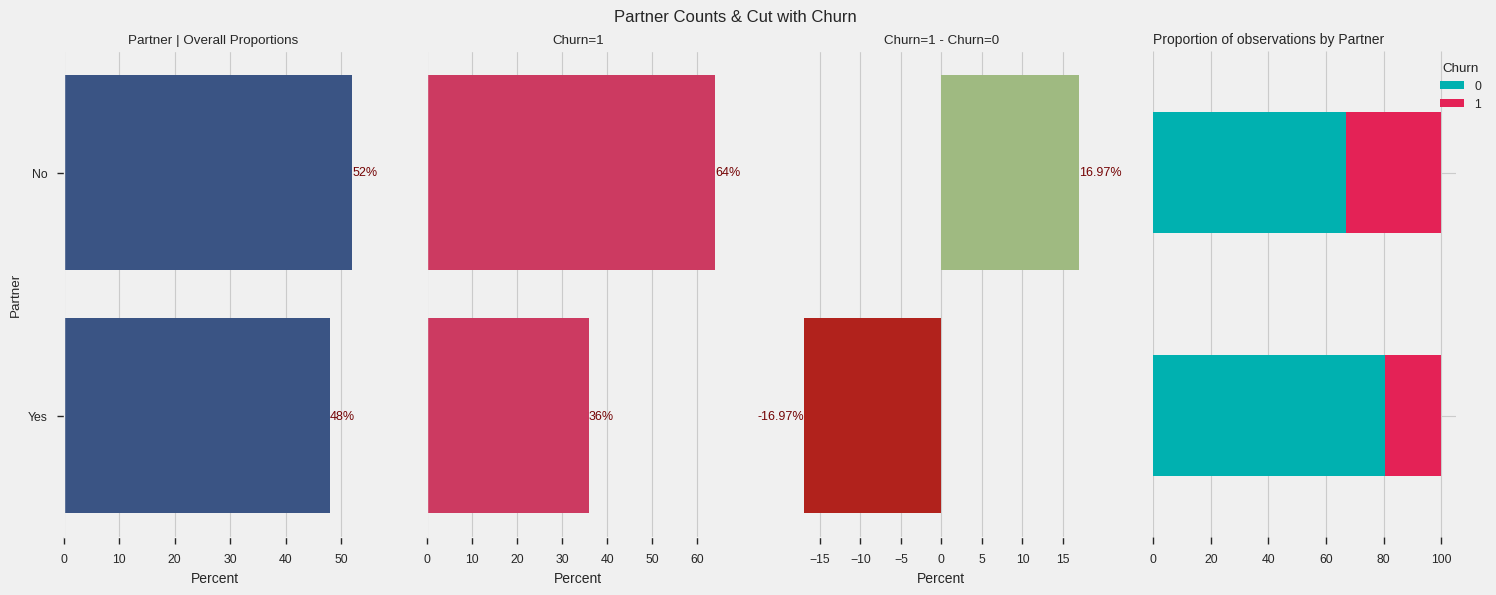

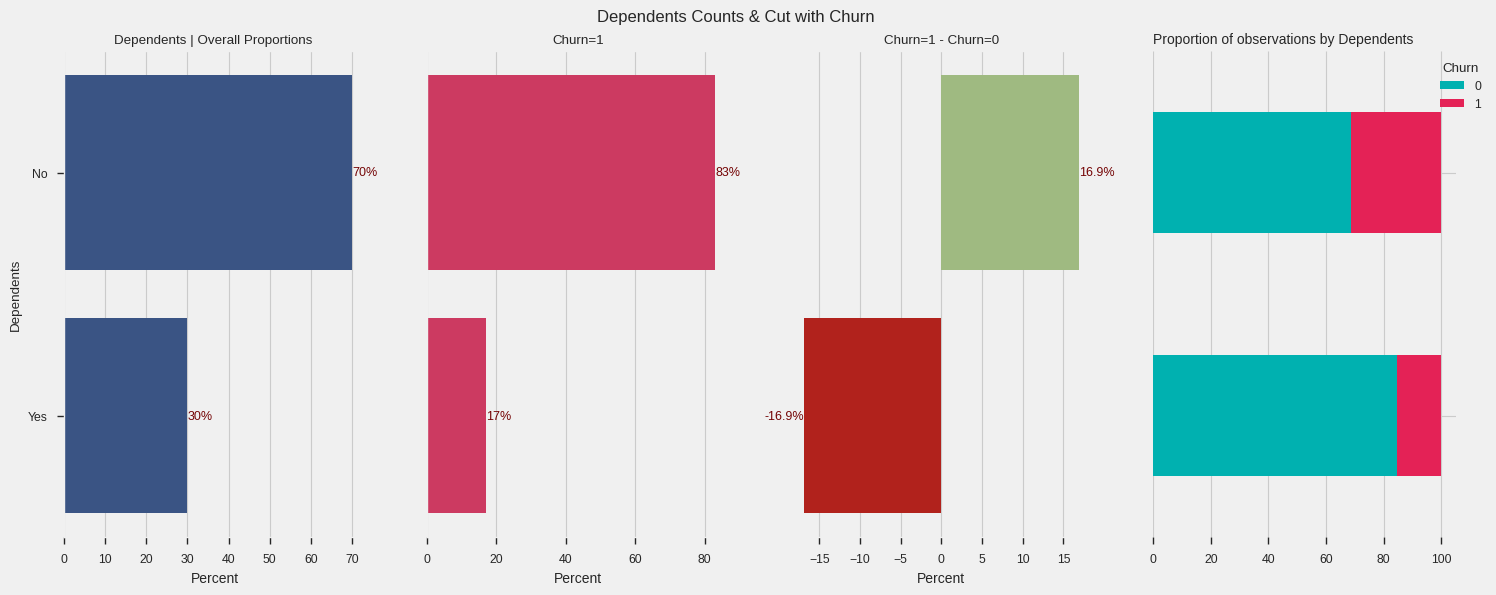

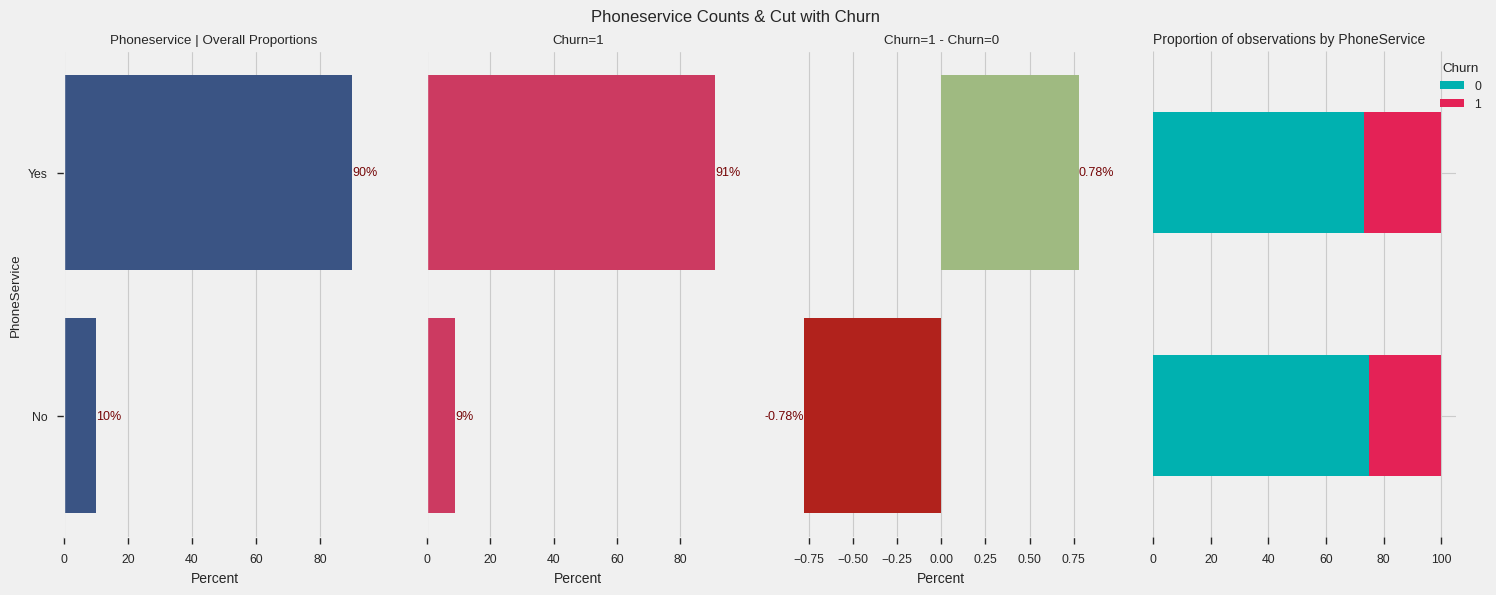

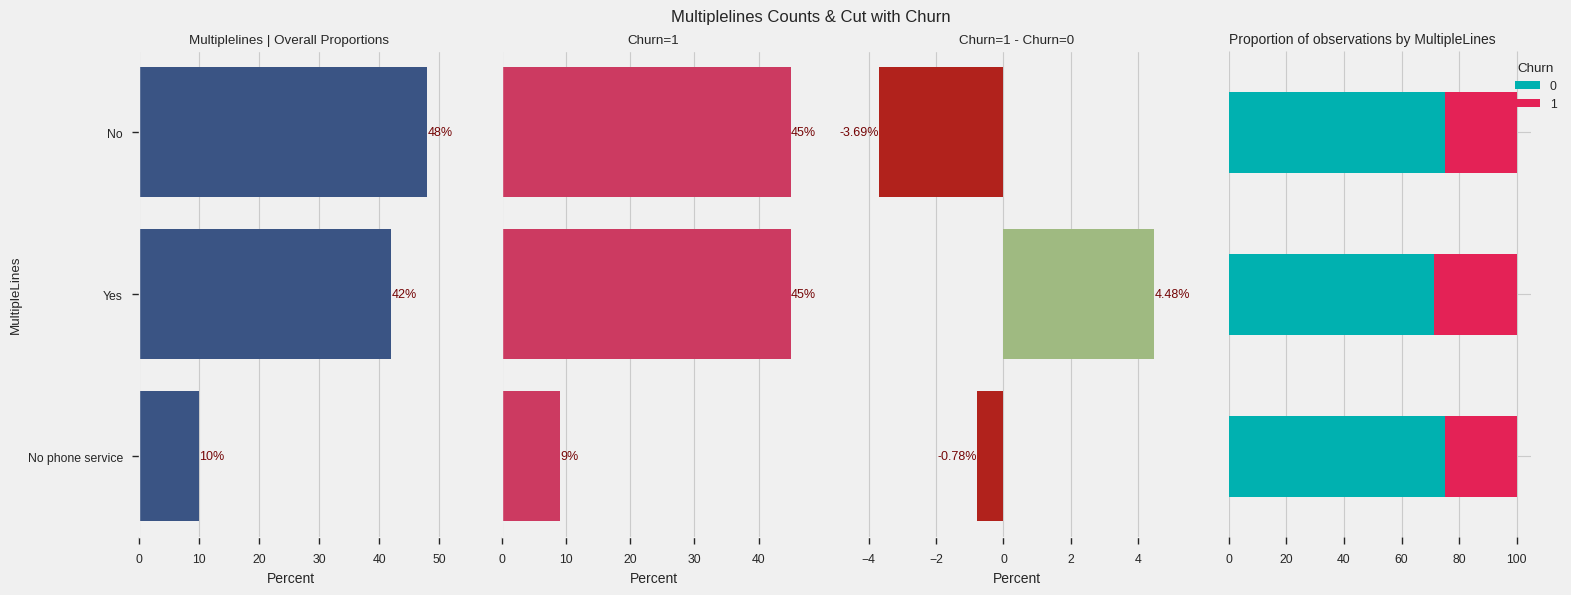

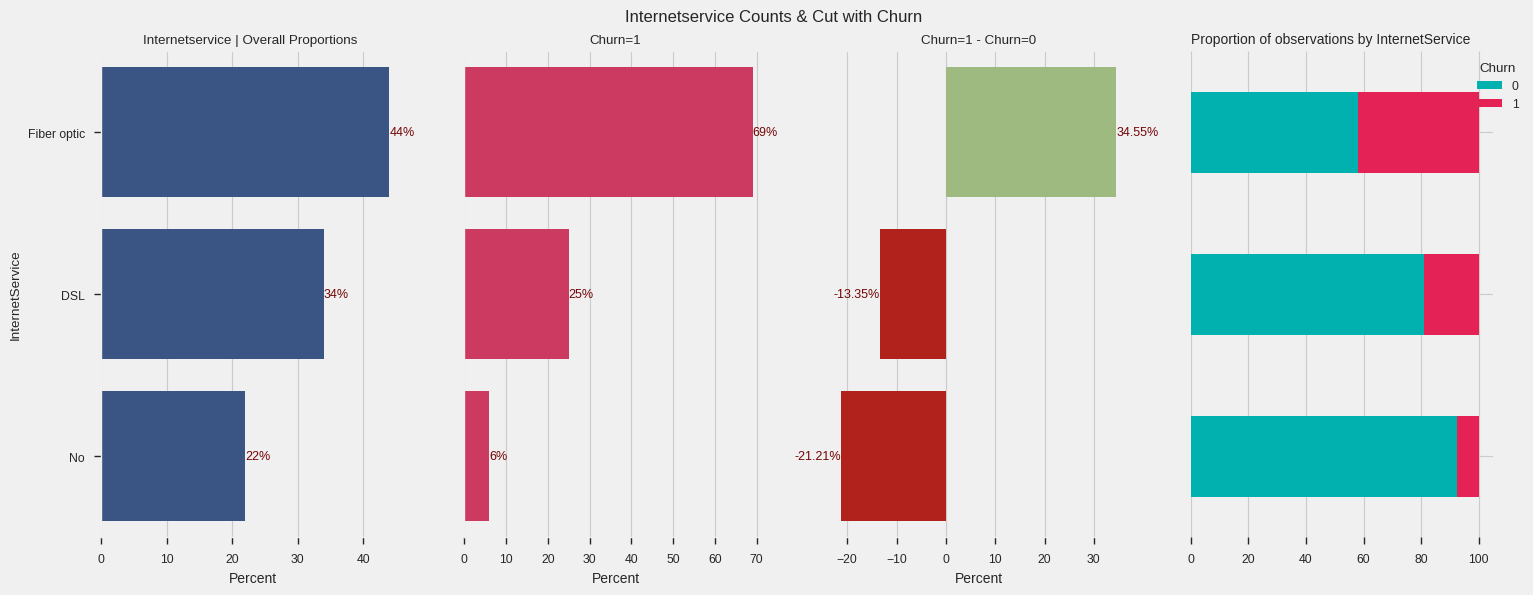

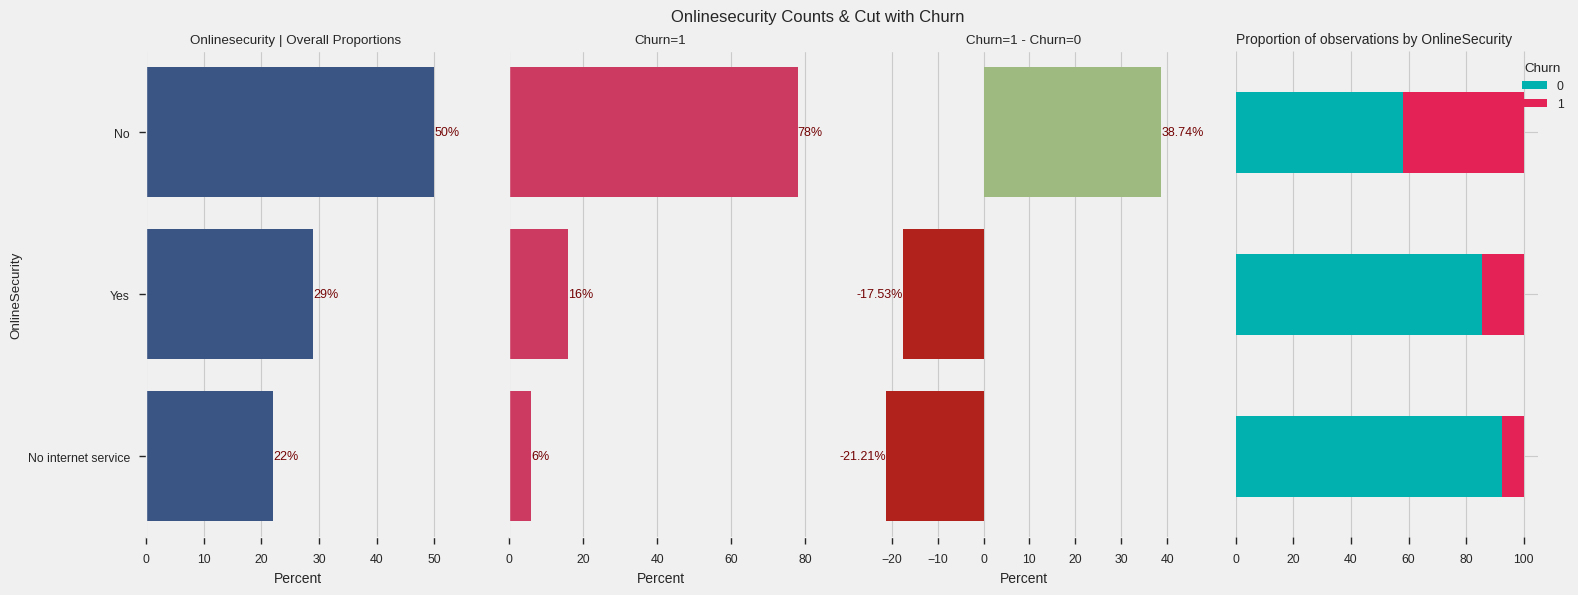

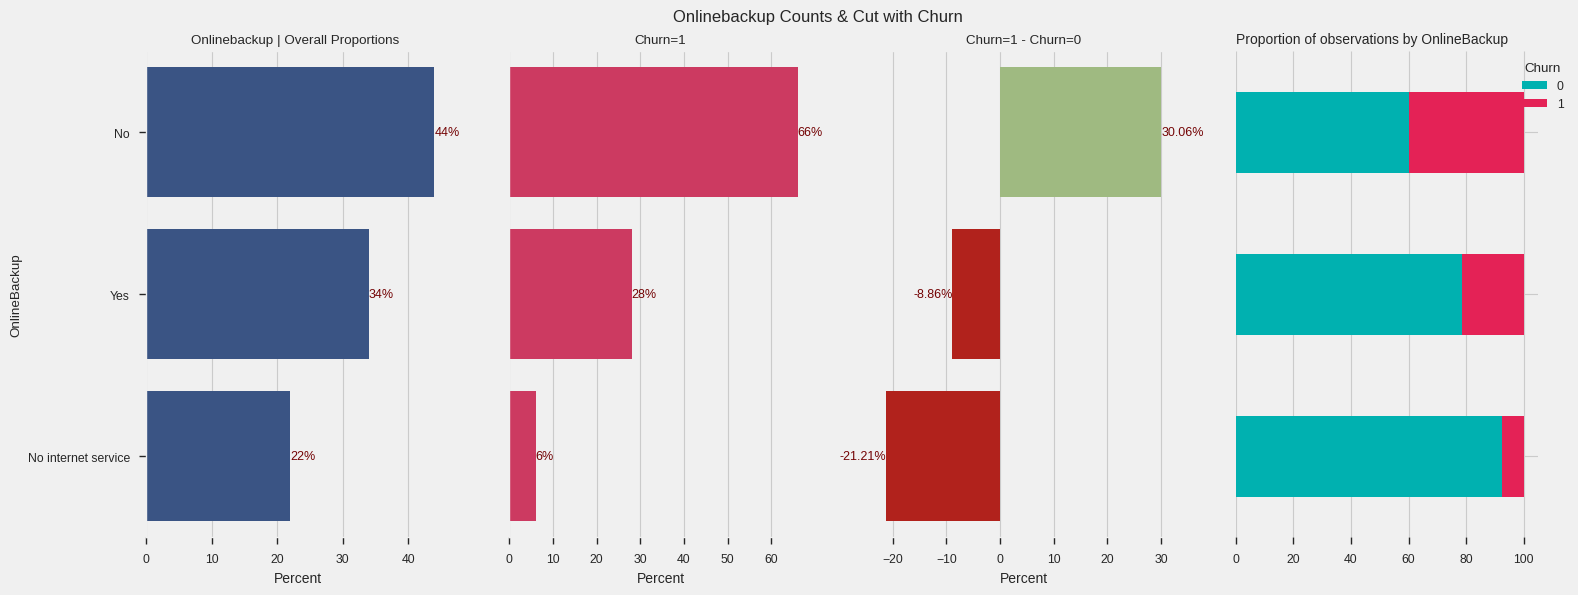

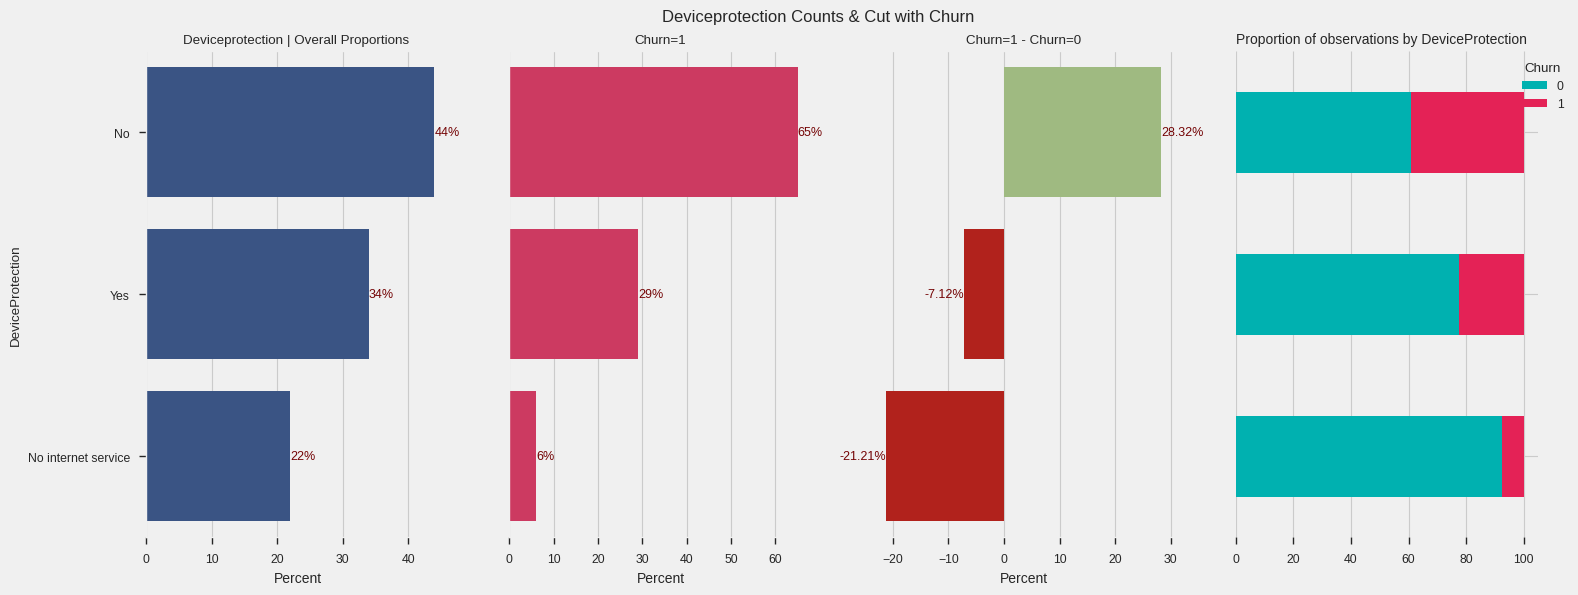

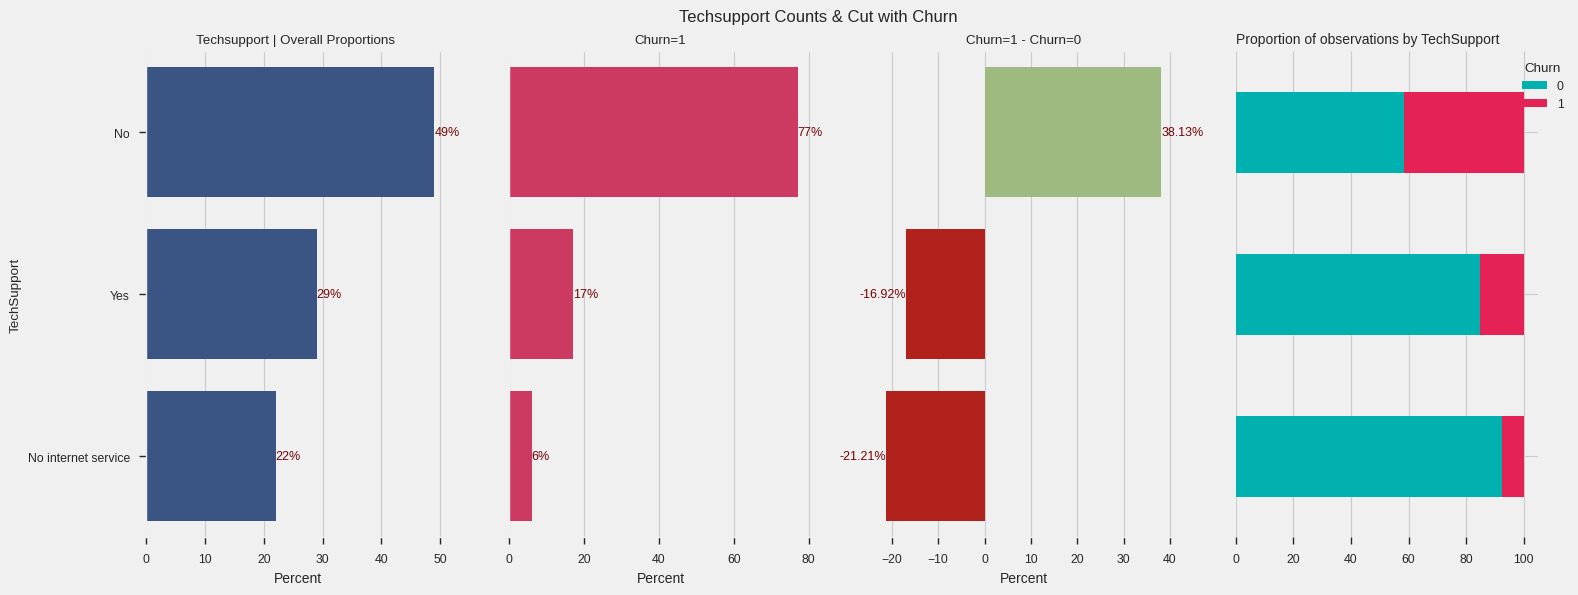

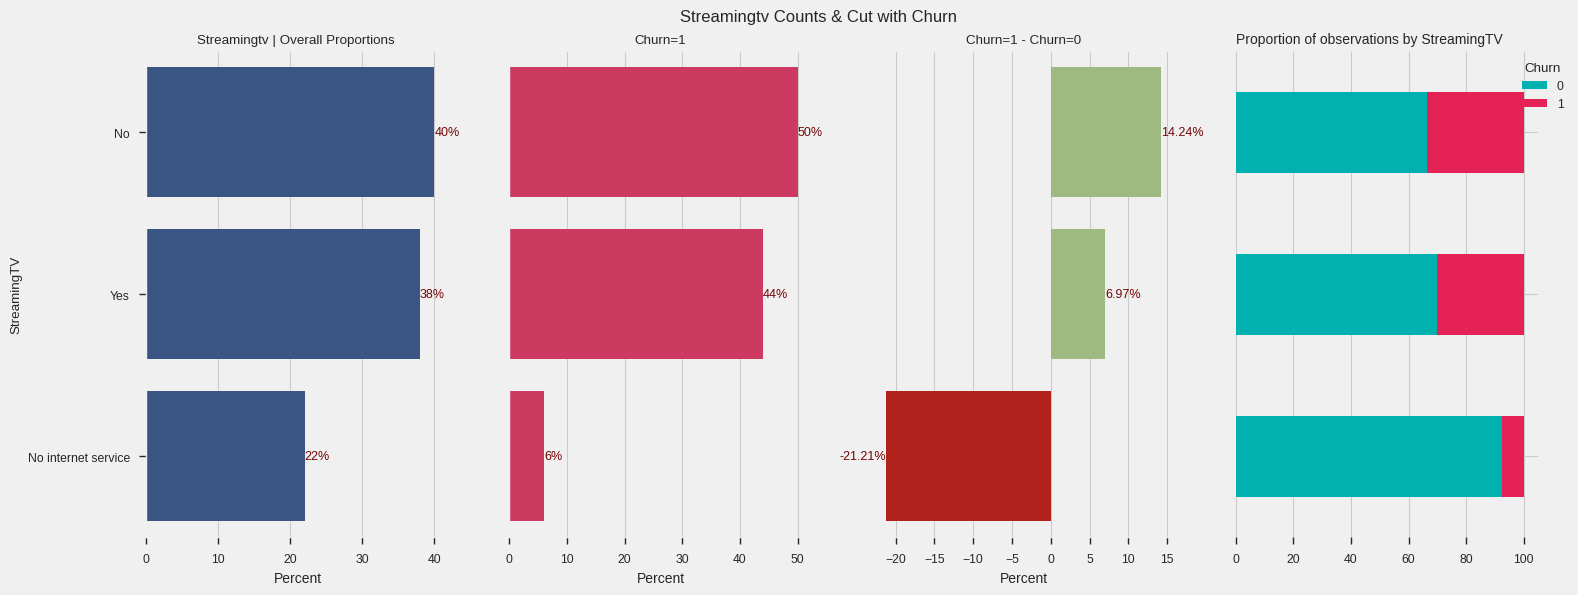

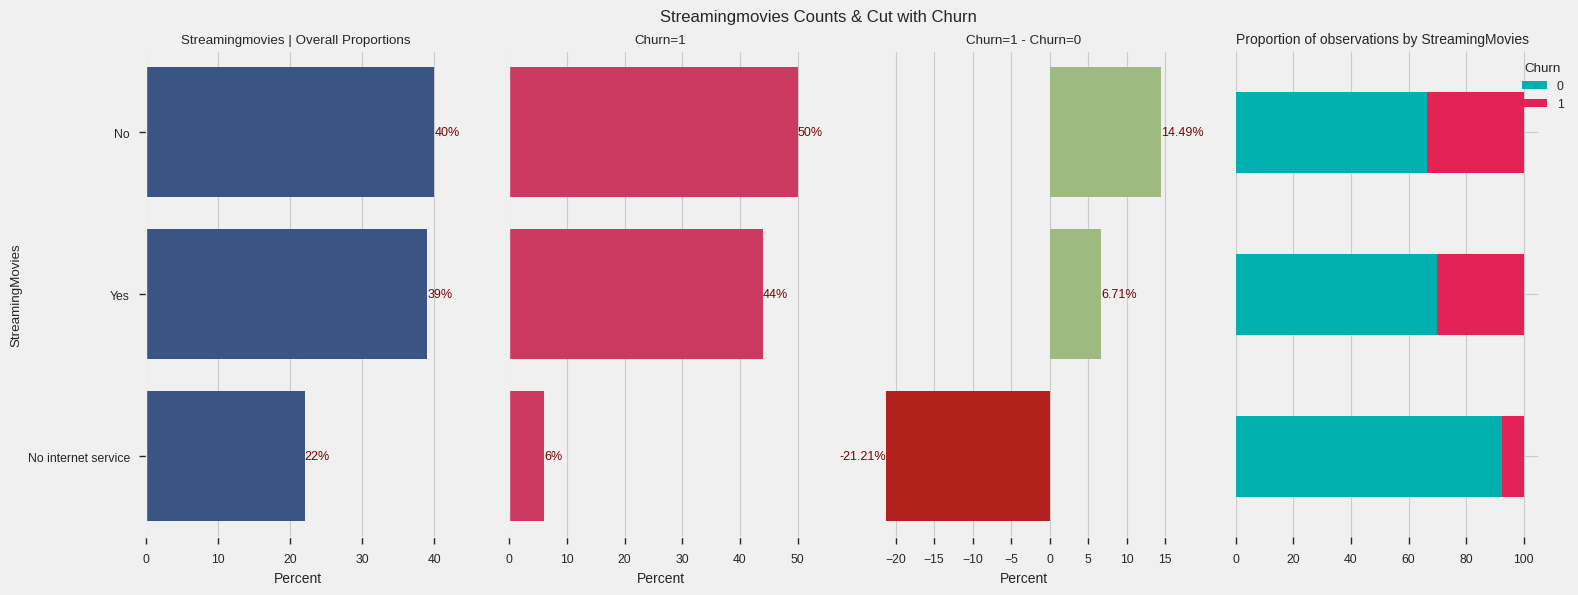

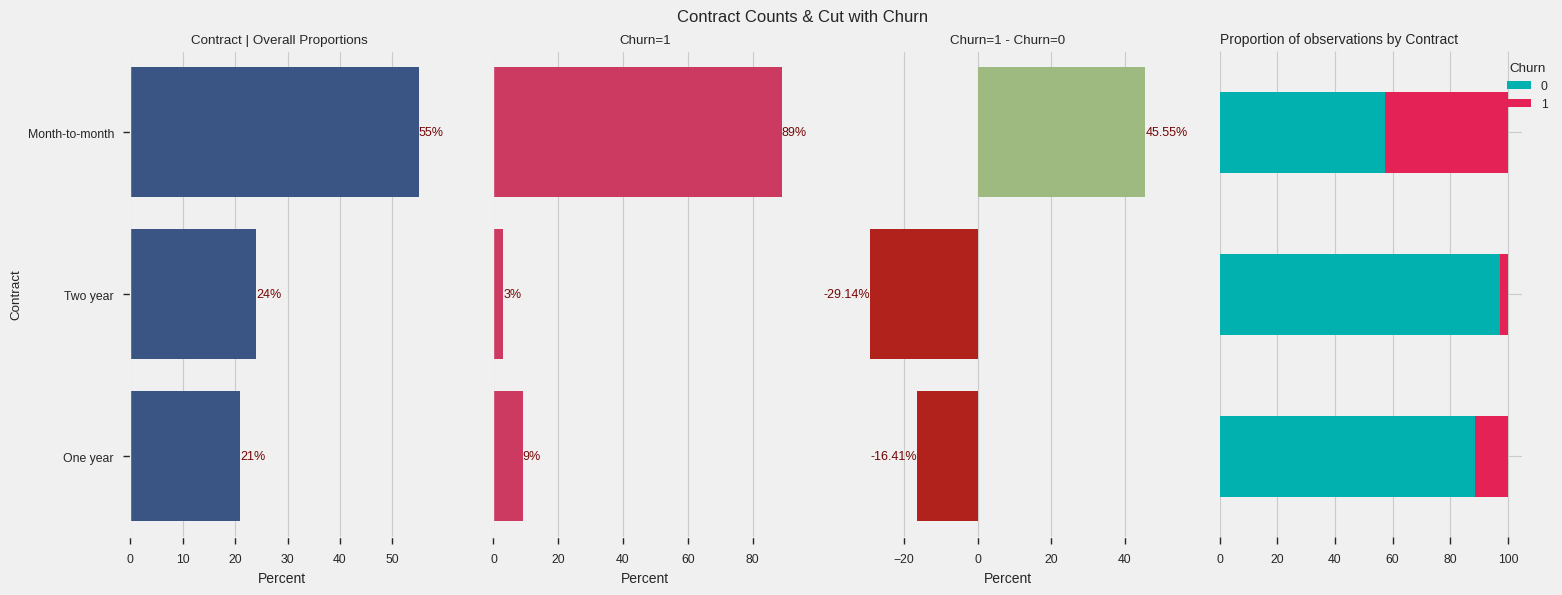

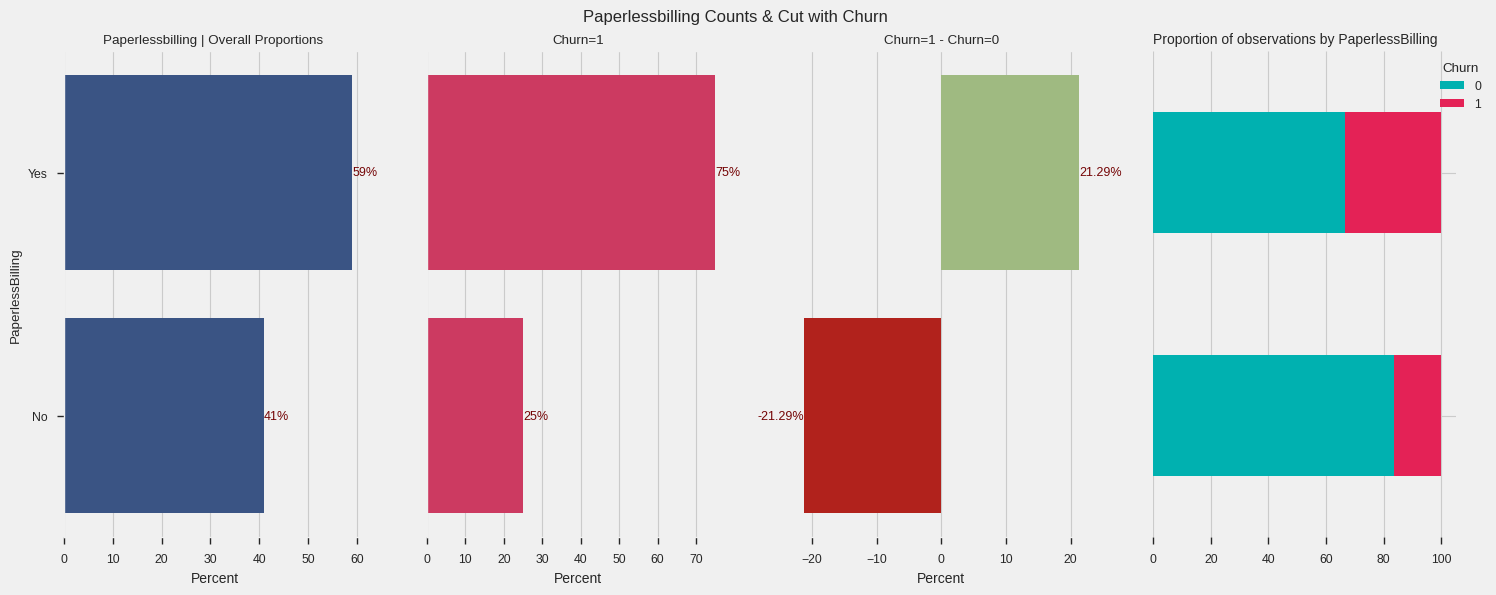

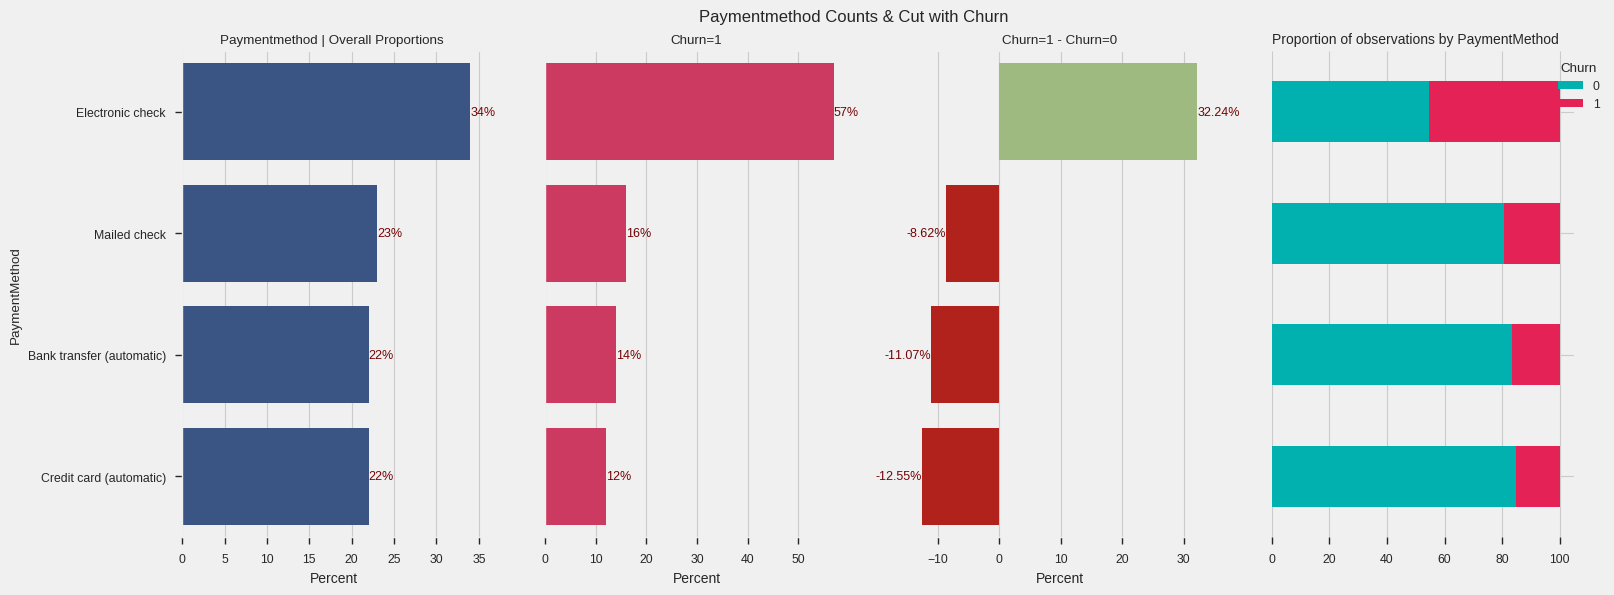

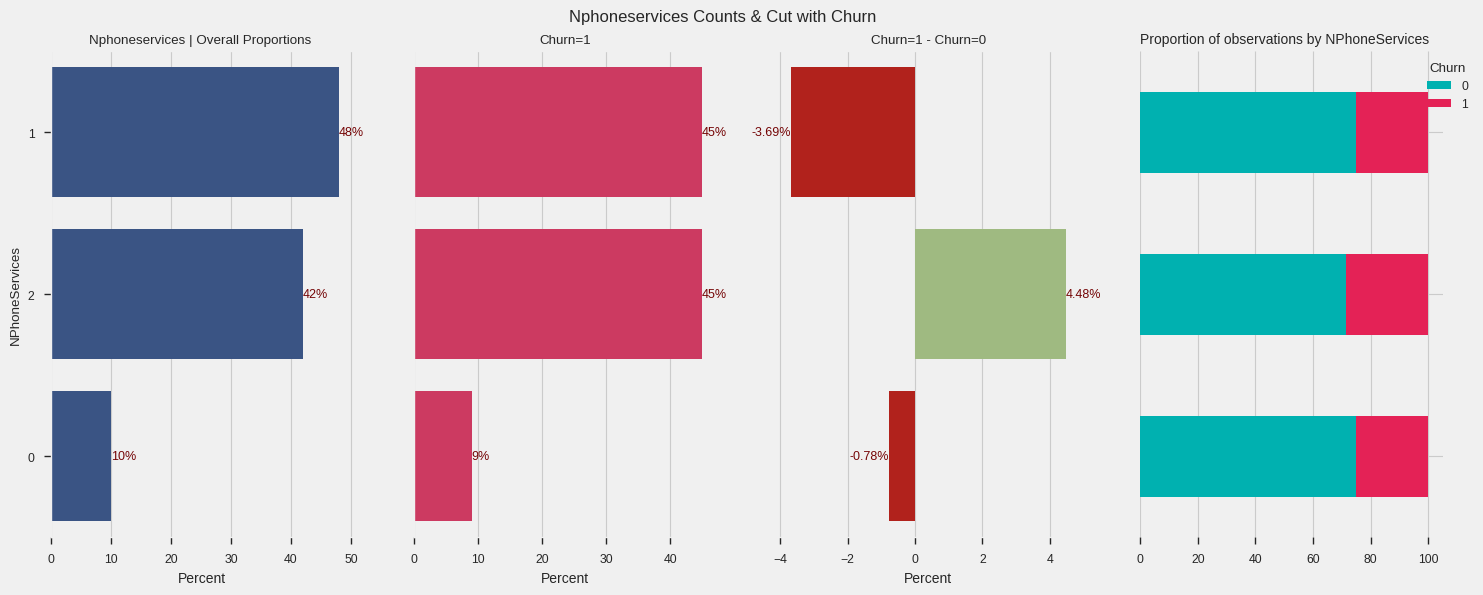

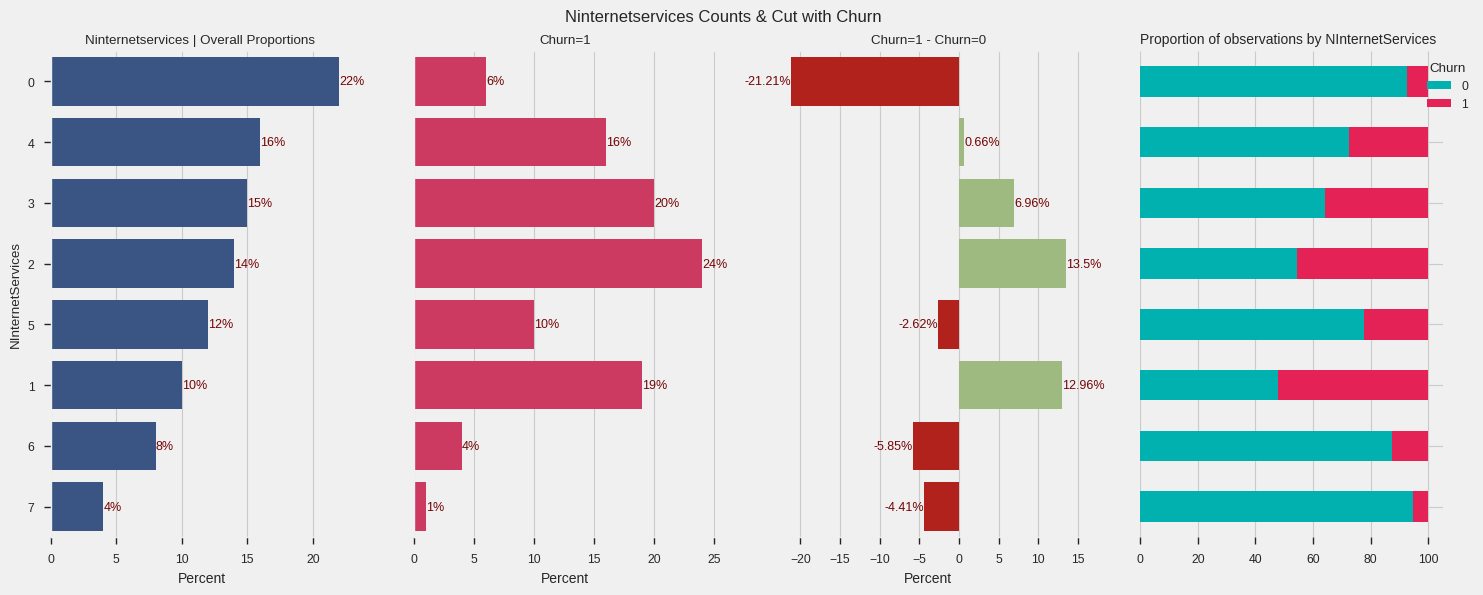

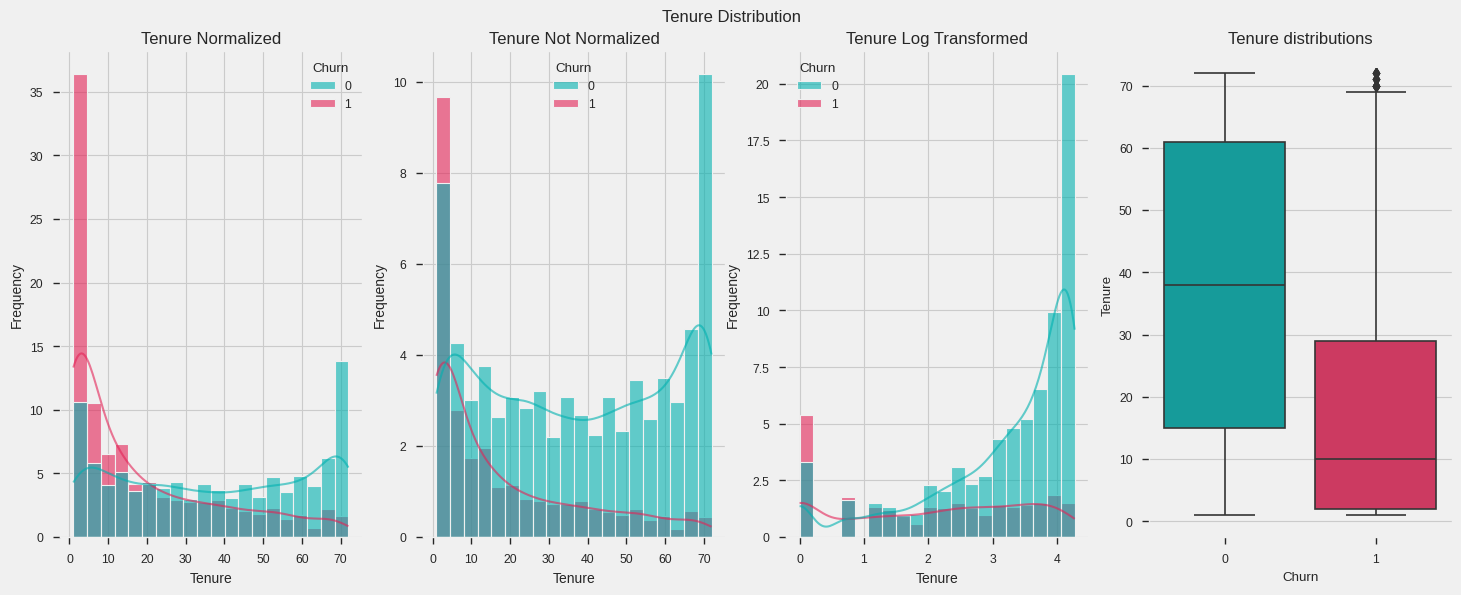

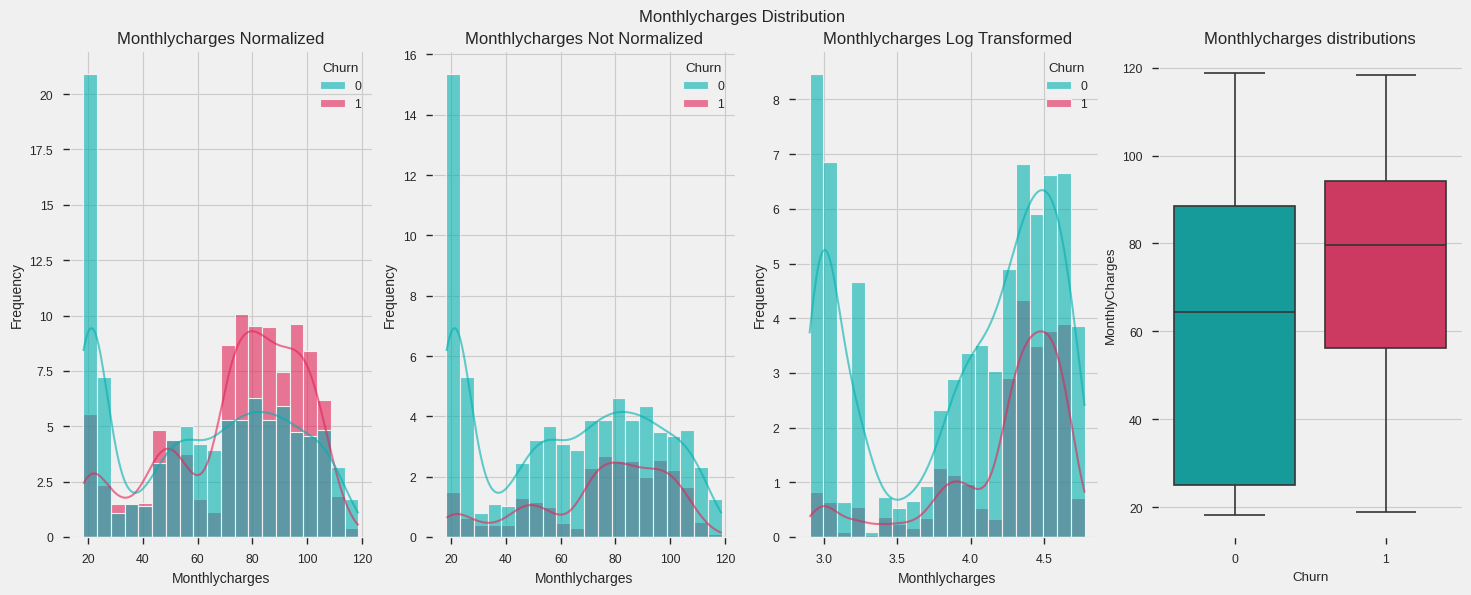

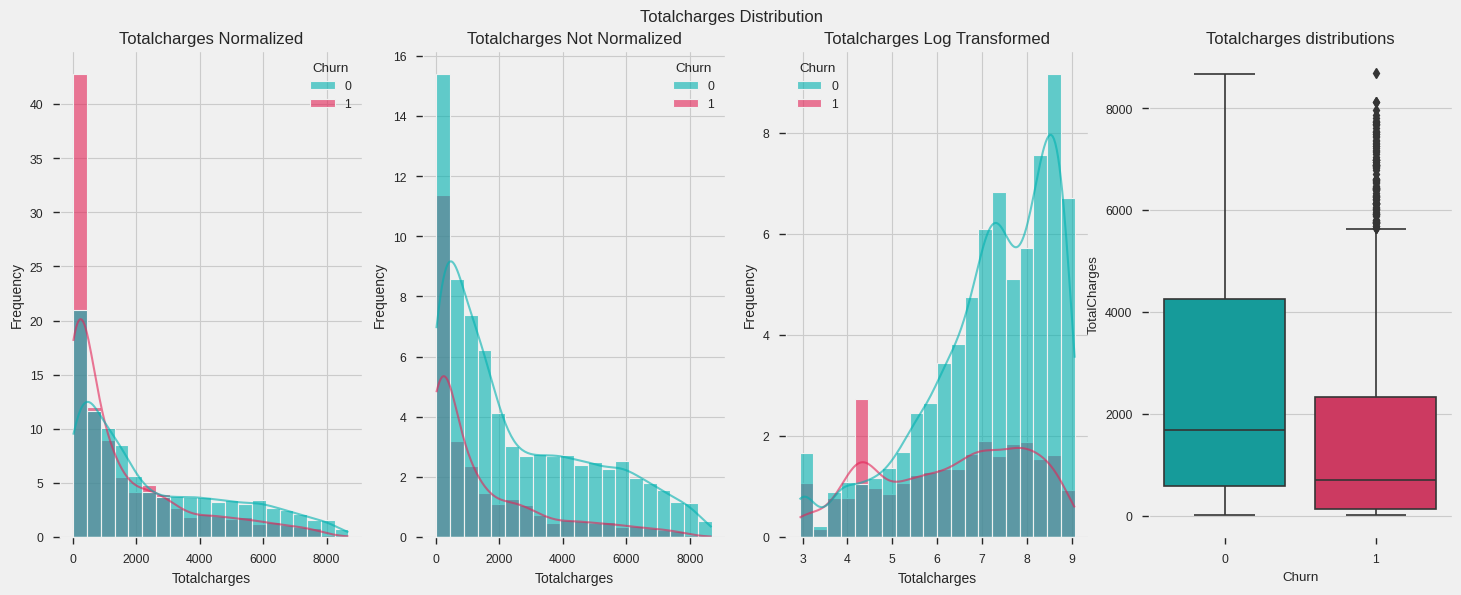

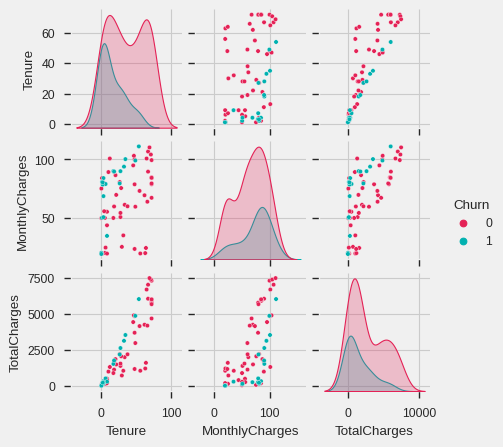

,Tenure,MonthlyCharges,TotalCharges,Churn
Tenure,nan,nan,nan,nan
MonthlyCharges,0.25,nan,nan,nan
TotalCharges,0.83,0.65,nan,nan
Churn,-0.35,0.19,-0.20,nan


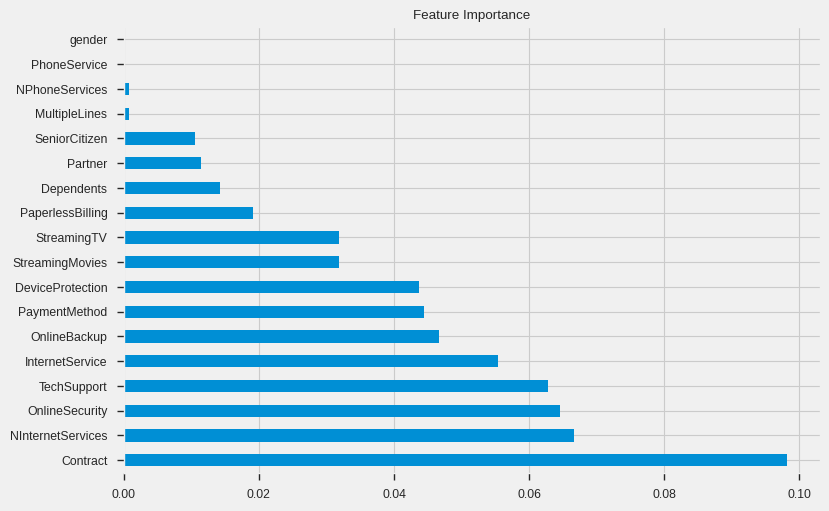

In [7]:
eda = helpers.EDAHelper(df, TARGET_NAME)
eda.init_diagnostic()

In [8]:
df['row_count'] =1

# 70% take both phone and internet services
display((pd.pivot_table(
    df.assign(hasInternet = lambda x: pd.to_numeric(x['NInternetServices'])>0, hasPhone= lambda x: pd.to_numeric(x['NPhoneServices'])>0),
    values='row_count',
    index='hasInternet', 
    columns='hasPhone', 
    aggfunc=np.sum, 
    margins=True).apply(lambda x: 100 * x / 7032)).style.format(precision=0))

# wide spread in services taken
display(pd.pivot_table(df, values='row_count', index='NInternetServices', columns='NPhoneServices', aggfunc=np.sum, margins=True)
 .apply(lambda x: 100 * x / x.All.max())
 .style.format(precision=0)
 .background_gradient())

df.drop('row_count', axis=1, inplace=True)

hasPhone,False,True,All
hasInternet,,,
False,nan,22,22
True,10,69,78
All,10,90,100


NPhoneServices,0,1,2,All
NInternetServices,,,,
0,0,35,11,22
1,12,12,7,10
2,17,15,12,14
3,21,13,15,15
4,22,12,19,16
5,14,8,17,12
6,10,5,12,8
7,4,2,7,4
All,100,100,100,100


In [9]:
# telephony only customers very sticky (old?)
# internet+telephony customers have increasing loyalty with services taken

pd.pivot(
    (df
    .assign(row_count=1)
    .groupby(by=['NInternetServices', 'NPhoneServices'])
    .sum()
    .assign(churn_rate= lambda x: x.Churn / x.row_count)
    .loc[:, 'churn_rate']
    .reset_index()),
    index='NInternetServices', columns='NPhoneServices').style.format('{:,.2%}')


## Pre-processing

1. One-hot encode features
2. Scale numerical features
3. Drop useless/ highly correlated features
4. Impute any missing data
5. Train/ test split

In [11]:
# pipeline and model
pre = ColumnTransformer([('cat', OneHotEncoder(sparse=False, drop='first'), cat_cols), 
                        ('num', StandardScaler(), num_cols)])
model = GradientBoostingClassifier()
ppl = Pipeline([('preprocessor', pre), ('classifier', model)])
cv = StratifiedKFold(n_splits=5)

param_grid = {
    #'classifier__C': np.logspace(-4, 4, 4) 
    'classifier__max_depth': [3, 5, 7, 10, 15, 20]
}

scorer = {
    #'lift_score': make_scorer(lift_score),
    'roc_auc':'roc_auc',
    'f1':'f1',
    'f1_macro':'f1_macro',
    'f2': make_scorer(fbeta_score, beta=2),
    'recall':'recall',
    'precision':'precision',
    'average_precision':'average_precision'
}

search = GridSearchCV(ppl, 
                      param_grid, 
                      cv=cv, scoring=scorer, 
                      refit='f2', 
                      return_train_score=True)

search.fit(X_train, y_train)

#------------------------------------------------------------------------------
#check transformed data
transformed_data = ppl[:-1].fit_transform(X_train, y_train)
transformed_feats = ppl[:-1].get_feature_names_out()
display(pd.DataFrame(transformed_data, columns=transformed_feats).head(5))


,cat__gender_Male,cat__SeniorCitizen_Yes,cat__Partner_Yes,cat__Dependents_Yes,cat__PhoneService_Yes,cat__MultipleLines_No phone service,cat__MultipleLines_Yes,cat__InternetService_Fiber optic,cat__InternetService_No,cat__OnlineSecurity_No internet service,cat__OnlineSecurity_Yes,cat__OnlineBackup_No internet service,cat__OnlineBackup_Yes,cat__DeviceProtection_No internet service,cat__DeviceProtection_Yes,cat__TechSupport_No internet service,cat__TechSupport_Yes,cat__StreamingTV_No internet service,cat__StreamingTV_Yes,cat__StreamingMovies_No internet service,cat__StreamingMovies_Yes,cat__Contract_One year,cat__Contract_Two year,cat__PaperlessBilling_Yes,cat__PaymentMethod_Credit card (automatic),cat__PaymentMethod_Electronic check,cat__PaymentMethod_Mailed check,num__Tenure,num__MonthlyCharges,num__TotalCharges,num__NPhoneServices,num__NInternetServices
0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.321816,0.981556,1.659900,1.045929,1.022589
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.267410,-0.971546,-0.562252,-2.062844,0.074811
2,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.444064,0.837066,1.756104,1.045929,0.548700
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.204646,0.641092,-0.908326,-0.508457,0.074811
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.669826,-0.808787,-0.101561,-2.062844,0.074811


Best parameter (CV score=0.535):
{'classifier__max_depth': 3}


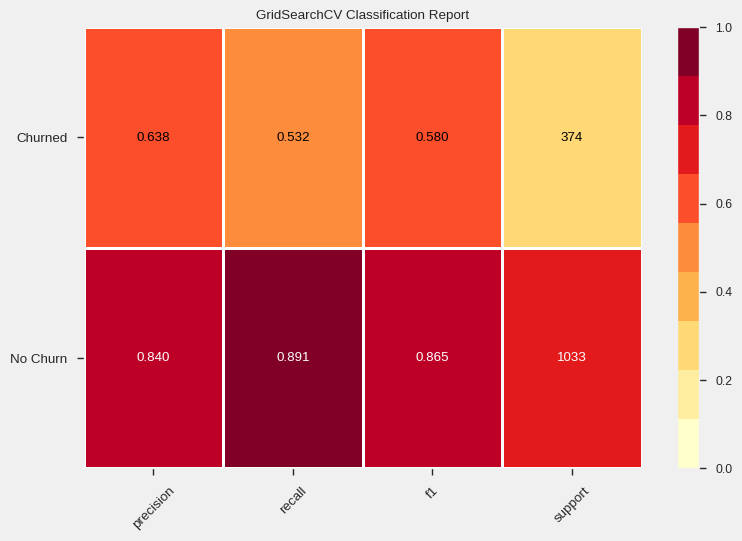

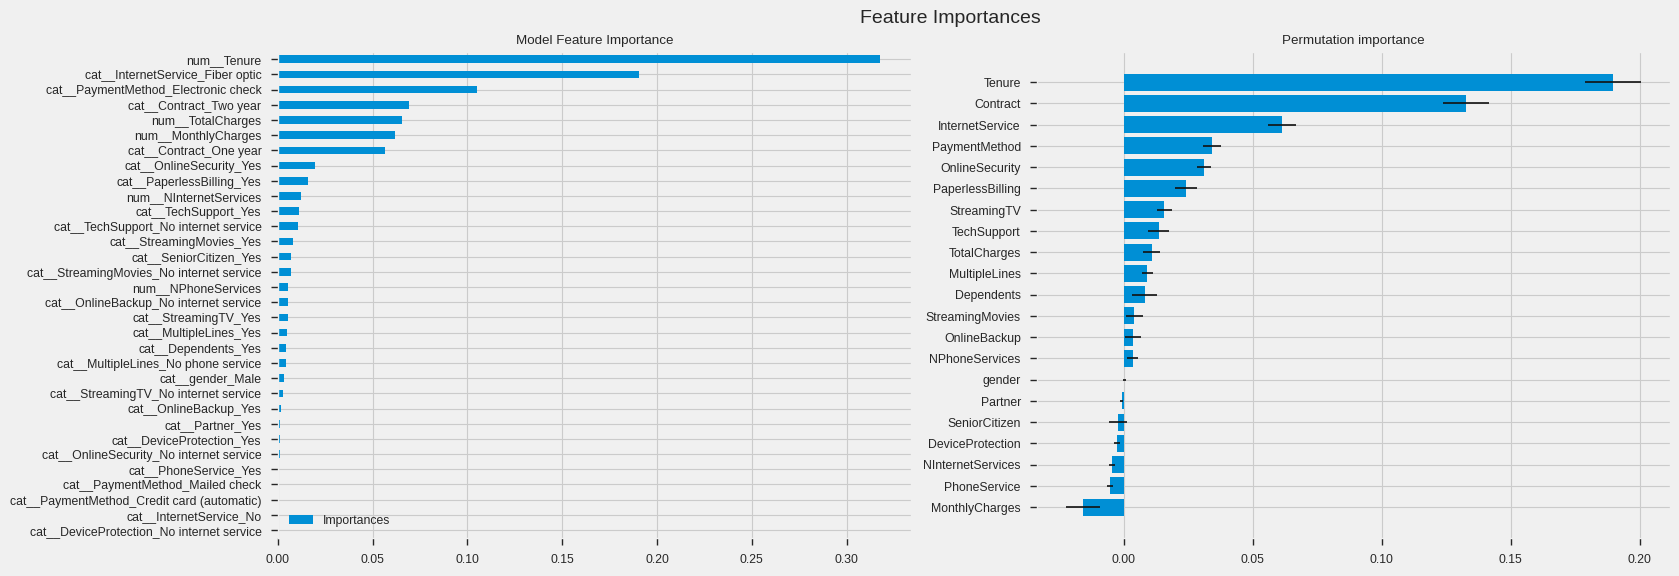

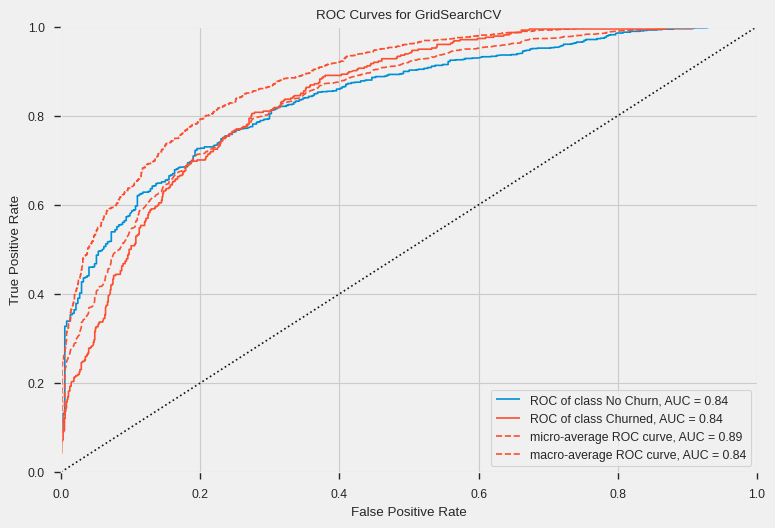

     pred_neg  pred_pos
neg       763       270
pos        84       290


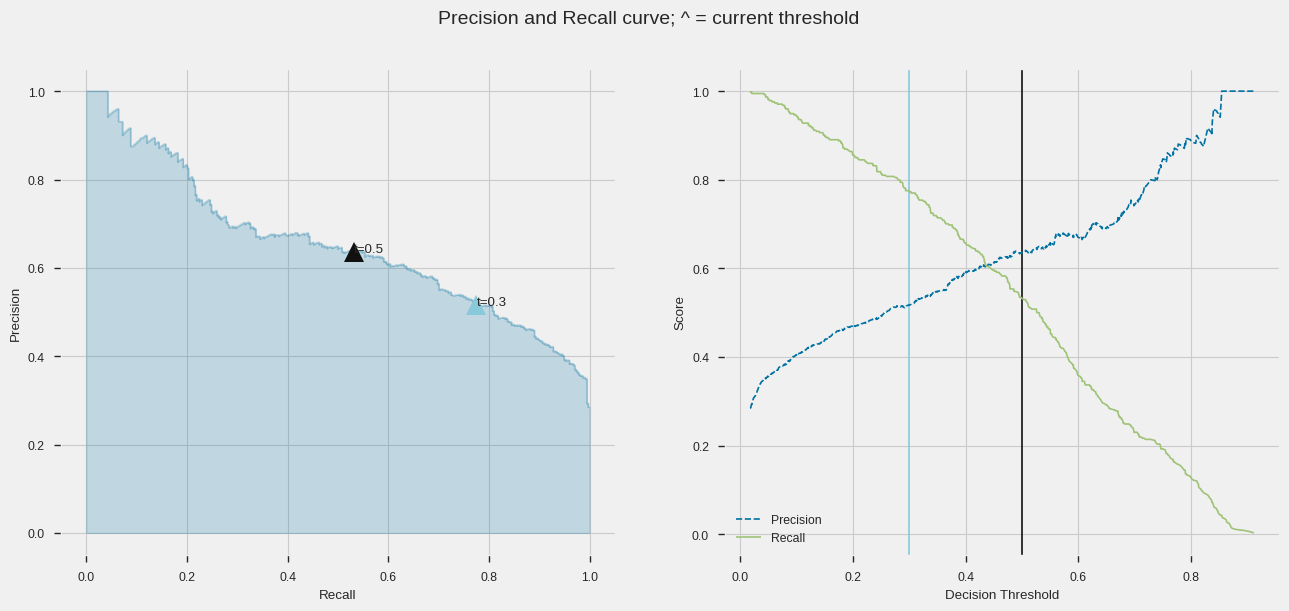

In [43]:
#------------------------------------------------------------------------------
# model eval
evaluator = helpers.ModelEvaluator(search, classes, X_train, X_test, y_train, y_test, "classifier")
evaluator.init_eval()

## With Oversampling

In [40]:
# Linear model (logistic regression)
lr = LogisticRegression(warm_start=True, max_iter=400)
# RandomForest
rf = RandomForestClassifier()
# XGB
xgb = XGBClassifier(tree_method="hist", verbosity=0, silent=True)
# Ensemble
lr_xgb_rf = VotingClassifier(estimators=[('lr', lr), ('xgb', xgb), ('rf', rf)], 
                             voting='soft')


# Pipeline
ppl_imb = imbPipeline([
    # Step 1: Impute and scale columns/features
    ('cleaning', ColumnTransformer([
        # Step 2.1: Apply steps for numerical features
        ('num',make_pipeline(
            #SimpleImputer(strategy='mean'),
            MinMaxScaler()),
         num_cols
        ),
        # Step 2.2 Apply steps for categorial features
        ('cat',make_pipeline(
            #SimpleImputer(strategy='most_frequent'),
            OneHotEncoder(sparse=False, handle_unknown='ignore', drop='first')),
         cat_cols
        )])
    ),
    
    # Step 2: Sampling
    ('smote', SMOTE()),
    
    # Step 3: Voting Classifier
    ('ensemble', lr_xgb_rf)
])

# Hyperparameter Tuning
params_imb = {
    #'ensemble__lr__solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'ensemble__lr__penalty': ['none', 'l1', 'l2', 'elasticnet'],
    #'ensemble__lr__C': loguniform(1e-5, 100),
    #'ensemble__xgb__learning_rate': [0.1],
    'ensemble__xgb__max_depth': [3, 5, 10, 15, 20],
    #'ensemble__xgb__min_child_weight': [10, 15, 20, 25],
    #'ensemble__xgb__colsample_bytree': [0.8, 0.9, 1],
    #'ensemble__xgb__n_estimators': [300, 400, 500, 600],
    #'ensemble__xgb__reg_alpha': [0.5, 0.2, 1],
    #'ensemble__xgb__reg_lambda': [2, 3, 5],
    #'ensemble__xgb__gamma': [1, 2, 3],
    'ensemble__rf__max_depth': [7, 10, 15, 20],
    #'ensemble__rf__min_samples_leaf': [1, 2, 4],
    #'ensemble__rf__min_samples_split': [2, 5, 10],
    #'ensemble__rf__n_estimators': [300, 400, 500, 600],
}

rsf = StratifiedKFold(n_splits=5)
clf = RandomizedSearchCV(ppl_imb, params_imb,scoring=scorer, refit='f2', verbose=2, cv=rsf)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ensemble__lr__penalty=l1, ensemble__rf__max_depth=7, ensemble__xgb__max_depth=3; total time=   0.3s
[CV] END ensemble__lr__penalty=l1, ensemble__rf__max_depth=7, ensemble__xgb__max_depth=3; total time=   0.2s
[CV] END ensemble__lr__penalty=l1, ensemble__rf__max_depth=7, ensemble__xgb__max_depth=3; total time=   0.1s
[CV] END ensemble__lr__penalty=l1, ensemble__rf__max_depth=7, ensemble__xgb__max_depth=3; total time=   0.1s
[CV] END ensemble__lr__penalty=l1, ensemble__rf__max_depth=7, ensemble__xgb__max_depth=3; total time=   0.1s
[CV] END ensemble__lr__penalty=none, ensemble__rf__max_depth=20, ensemble__xgb__max_depth=5; total time=   2.8s
[CV] END ensemble__lr__penalty=none, ensemble__rf__max_depth=20, ensemble__xgb__max_depth=5; total time=   3.0s
[CV] END ensemble__lr__penalty=none, ensemble__rf__max_depth=20, ensemble__xgb__max_depth=5; total time=   2.9s
[CV] END ensemble__lr__penalty=none, ensemble__rf__max_dep

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('cleaning',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('minmaxscaler',
                                                                                                MinMaxScaler())]),
                                                                               Index(['Tenure', 'MonthlyCharges', 'TotalCharges', 'NPhoneServices',
       'NInternetServices'],
      dtype='object')),
                                                                              ('cat',
                                                                               Pipeline(steps=[('onehotencoder...
                   param_distributions={'ensemble__lr__penalty': ['none', 'l1',
                                                                  'l2',
                                                                  'elasticnet'],
                                        'ensemble__rf__max_depth': [7, 10, 15,
                                                                    20],
                                        'ensemble__xgb__max_depth': [3, 5, 10,
                                                                     15, 20]},
                   refit='recall',
                   scoring={'average_precision': 'average_precision',
                            'f1': 'f1', 'f1_macro': 'f1_macro',
                            'f2': make_scorer(fbeta_score, beta=2),
                            'precision': 'precision', 'recall': 'recall',
                            'roc_auc': 'roc_auc'},
                   verbose=2)

In [94]:
from importlib import reload  # Python 3.4+
reload(helpers)

<module 'utils.helpers' from '/home/david.zhao/value-ml/utils/helpers.py'>

Best parameter (CV score=0.679):
{'ensemble__xgb__max_depth': 5, 'ensemble__rf__max_depth': 15, 'ensemble__lr__penalty': 'none'}


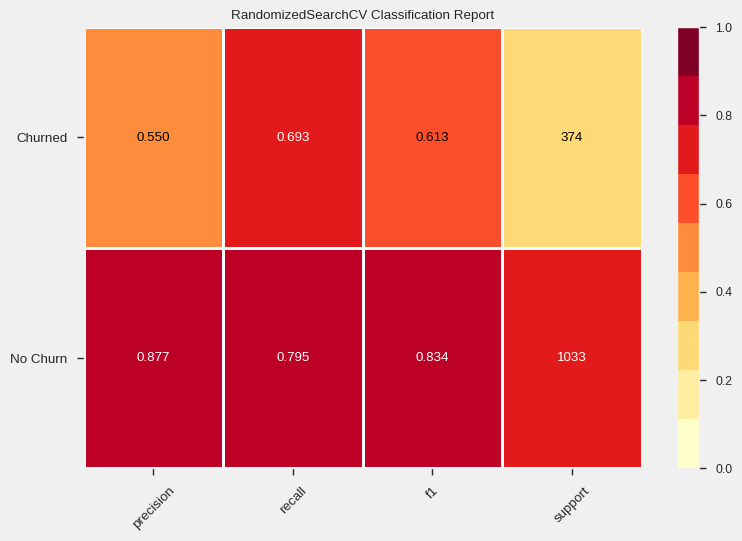

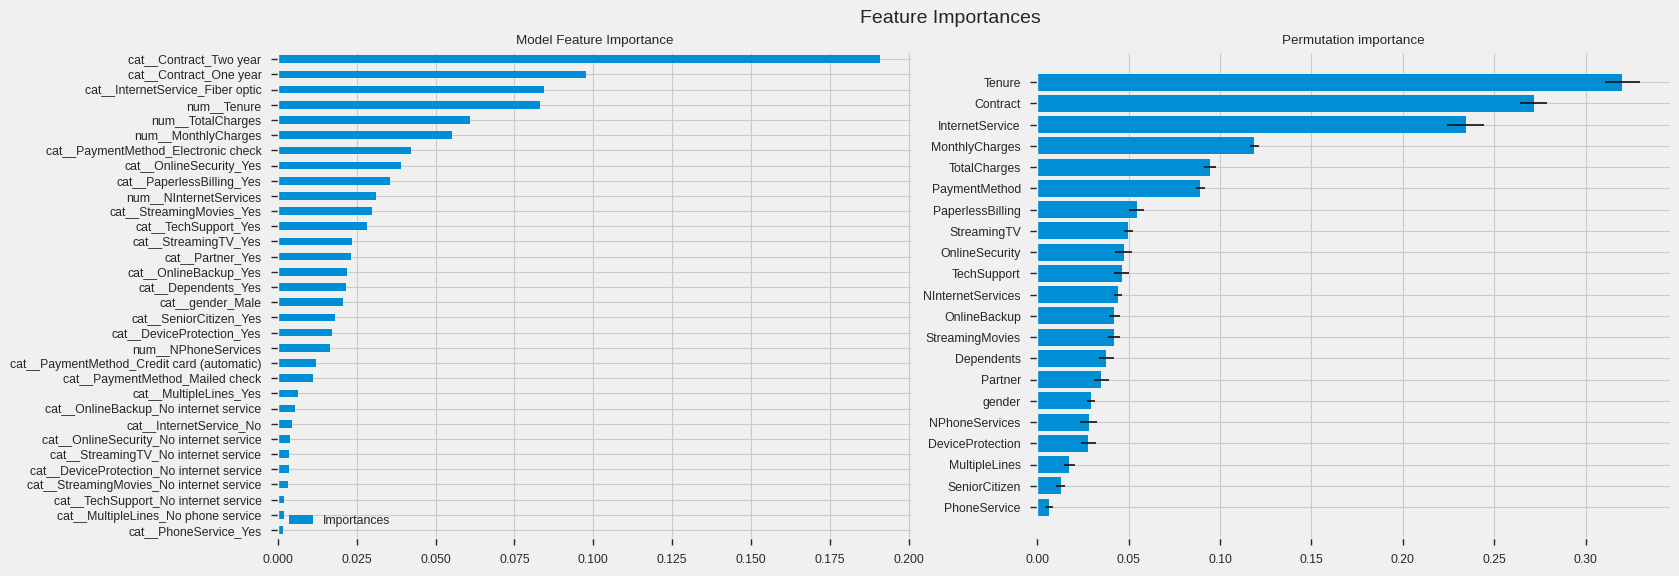

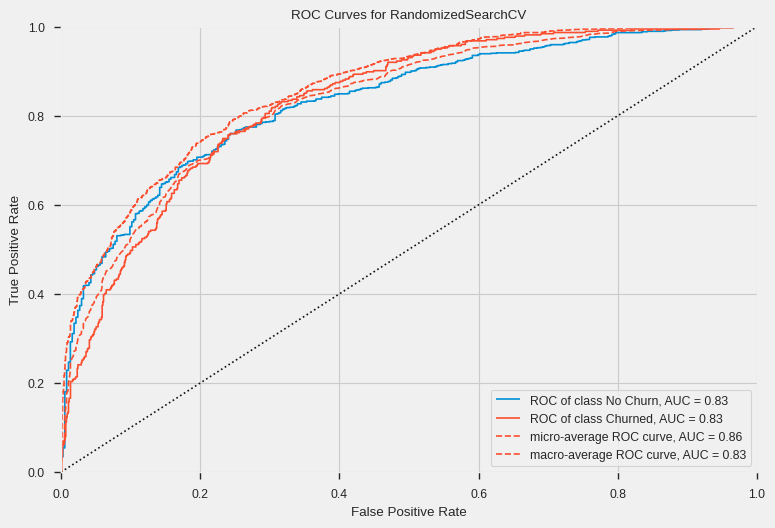

     pred_neg  pred_pos
neg       667       366
pos        54       320


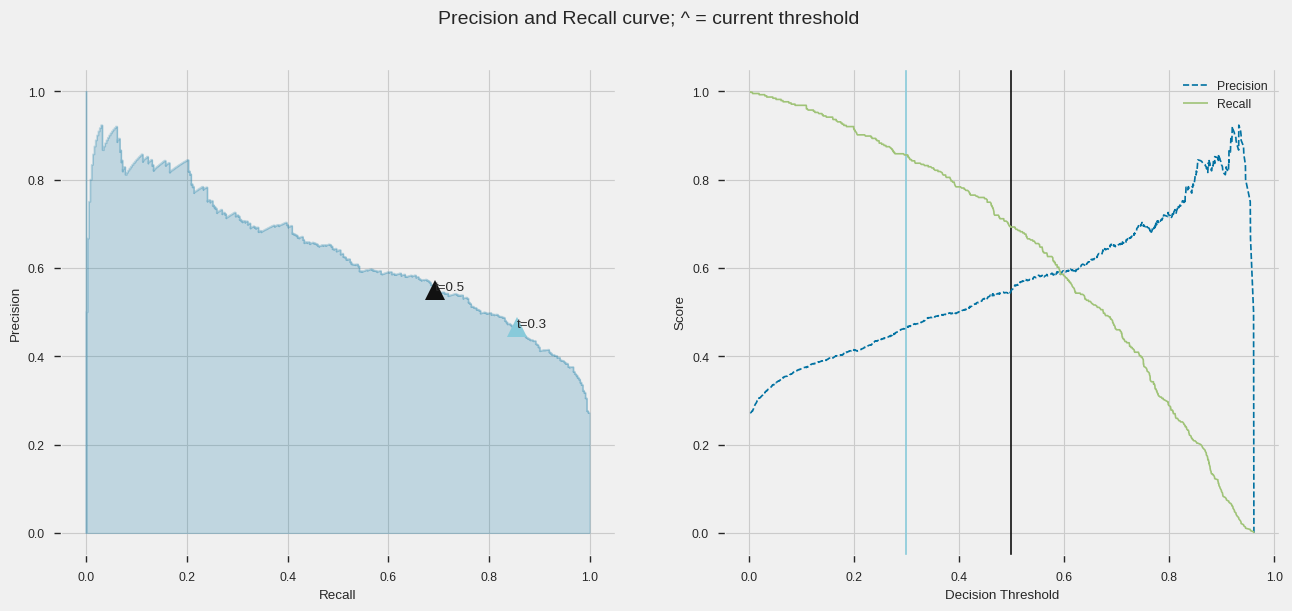

In [95]:
#------------------------------------------------------------------------------
# model eval
evaluator_imb = helpers.ModelEvaluator(clf, classes, X_train, X_test, y_train, y_test, "ensemble", voting=True)
evaluator_imb.init_eval()